# Introduction to Explainable AI using the Iris Dataset

In this assignment, we delve into the realm of Explainable AI (XAI) using the well-known Iris dataset. Our focus will be on understanding and interpreting machine learning models through various explainers.

1. Data Augmentation:
The Iris dataset, known for its limited size, is enhanced through data augmentation. This process involves the injection of random noise into the dataset, thereby increasing its volume and variability without straying far from its original characteristics.

2. Training the Autoencoder:
We embark on training an autoencoder, which is a crucial step in our experiment. The training is conducted exclusively on the 'normal' class data. To bolster the autoencoder's ability to differentiate between normal and anomalous data, we introduce artificially generated anomalies. These anomalies are random data points that do not correlate with the other classes. The scaling of the data is tailored based on these normal observations, setting the foundation for effective anomaly detection.

3. Classifier Development:
Using the trained autoencoder, we construct a classifier. Its primary role is to distinguish between the normal class (Versicolor) and the anomalous classes (Setosa and Virginica). This classifier is fundamentally based on a loss threshold, a critical measure that differentiates normal data from anomalies.

  Note on Anomaly Detection: It's important to note that our anomaly detection approach assumes the exclusive knowledge of the normal class. The detection relies heavily on the loss statistics of the normal class, with anomalous classes not being directly used in training. However, the inclusion of random noise in training serves as a supplementary feature to enhance learning.

4. Metrics for Explainers:
As a key part of this assignment, you will calculate and analyze various metrics for selected explainers. These explainers can be rule-based or importance-based, such as SHAP (SHapley Additive exPlanations). The metrics to focus on include:
- Stability: Evaluating how consistent the explainer's output is across different runs or slight variations in input.
- Fidelity (excluding SHAP): Assessing how accurately the explanations reflect the behaviors of the underlying models.
- Consistency: This involves applying the explainer to the same instance multiple times (e.g., five times using LIME) and observing the variation in explanations.

This practical exercise aims to enhance understanding of how different explainers operate and to evaluate their effectiveness in making AI models more interpretable and transparent. Let's begin our journey towards making AI more explainable and trustworthy!

# Load Iris dataset and model

In [1]:
! mkdir serialised
! cd serialised && rm Iris_contrastive_model_versicolor_v9_noise_improved.pht
! cd serialised && rm Iris_contrastive_model_versicolor_v9_noise_improved__colab_version_3.pht
! cd serialised && wget https://github.com/mozo64/xai-evaluation-classes/raw/main/serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht
! cd serialised && wget https://github.com/mozo64/xai-evaluation-classes/raw/main/serialised/Iris_contrastive_model_versicolor_v9_noise_improved__colab_version_3.pht

! cd serialised && ls

rm: cannot remove 'Iris_contrastive_model_versicolor_v9_noise_improved.pht': No such file or directory
rm: cannot remove 'Iris_contrastive_model_versicolor_v9_noise_improved__colab_version_3.pht': No such file or directory
--2023-12-16 21:44:43--  https://github.com/mozo64/xai-evaluation-classes/raw/main/serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht [following]
--2023-12-16 21:44:43--  https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to ra

In [2]:
! pip install dill shap lime anchor-exp gower imbalanced-learn numdifftools
! apt-get install graphviz

! git clone -b main --single-branch https://github.com/sbobek/lux.git
%cd lux
! git submodule update --init --recursive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 931.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.1 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=8b50c1c70e48406b56d0e18d68625125ea7c4f82d8af9b59bef575705d70f4cf
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
  Created wheel for anchor-exp: filename=anchor_exp-0.0.2.0-py3-none-any.whl size=433497 sha256=6f417f43fa6510f9e565dbd7e1a5b70f24fe3559ff596a55c2745087516e6a34
  Stored in directory: /root/.cache/pip/wheels/e9/53/45/7e4602020c5e5069ccef79f1389adb8

In [3]:
! if[-f auxilliary_eval_classes.py]; then rm auxilliary_eval_classes.py; fi
! wget -O auxilliary_eval_classes.py https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/auxilliary_eval_classes.py

! tail auxilliary_eval_classes.py

# Importowanie modułu
# from importlib import reload

# import auxilliary_eval_classes

# Ponowne załadowanie modułu
# auxiliary_mushrooms = reload(auxilliary_eval_classes)

from auxilliary_eval_classes import iris_df, iris, print_loss, \
      normal_train_df, uniform_df_3, \
      X_normal_test_df, X_anomaly_1_test_df, X_anomaly_2_test_df, scaler, \
      NORMAL_CLASS, ANOMALY_CLASS_1, ANOMALY_CLASS_2, \
      get_losses_impl, assess_gaussianity_and_percentile, \
      IrisAutoencoder3, AnomalyClassifier


import numpy as np
np.int = int  # Fix deprecated
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch

import graphviz
from IPython.display import Image

from lux.lux import LUX
%cd ..

/bin/bash: -c: line 1: syntax error near unexpected token `then'
/bin/bash: -c: line 1: ` if[-f auxilliary_eval_classes.py]; then rm auxilliary_eval_classes.py; fi'
--2023-12-16 21:45:30--  https://raw.githubusercontent.com/mozo64/xai-evaluation-classes/main/auxilliary_eval_classes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16129 (16K) [text/plain]
Saving to: ‘auxilliary_eval_classes.py’

auxilliary_eval_cla 100%[===================>]  15.75K  --.-KB/s    in 0.001s  

2023-12-16 21:45:30 (12.9 MB/s) - ‘auxilliary_eval_classes.py’ saved [16129/16129]

X_anomaly_1_test_df = anomaly_1_gauss_df[
    ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X_anomaly_2_test_df = anomaly_2_gauss_df[
    ['sepal length (

# Iris dataset

## Original dataset

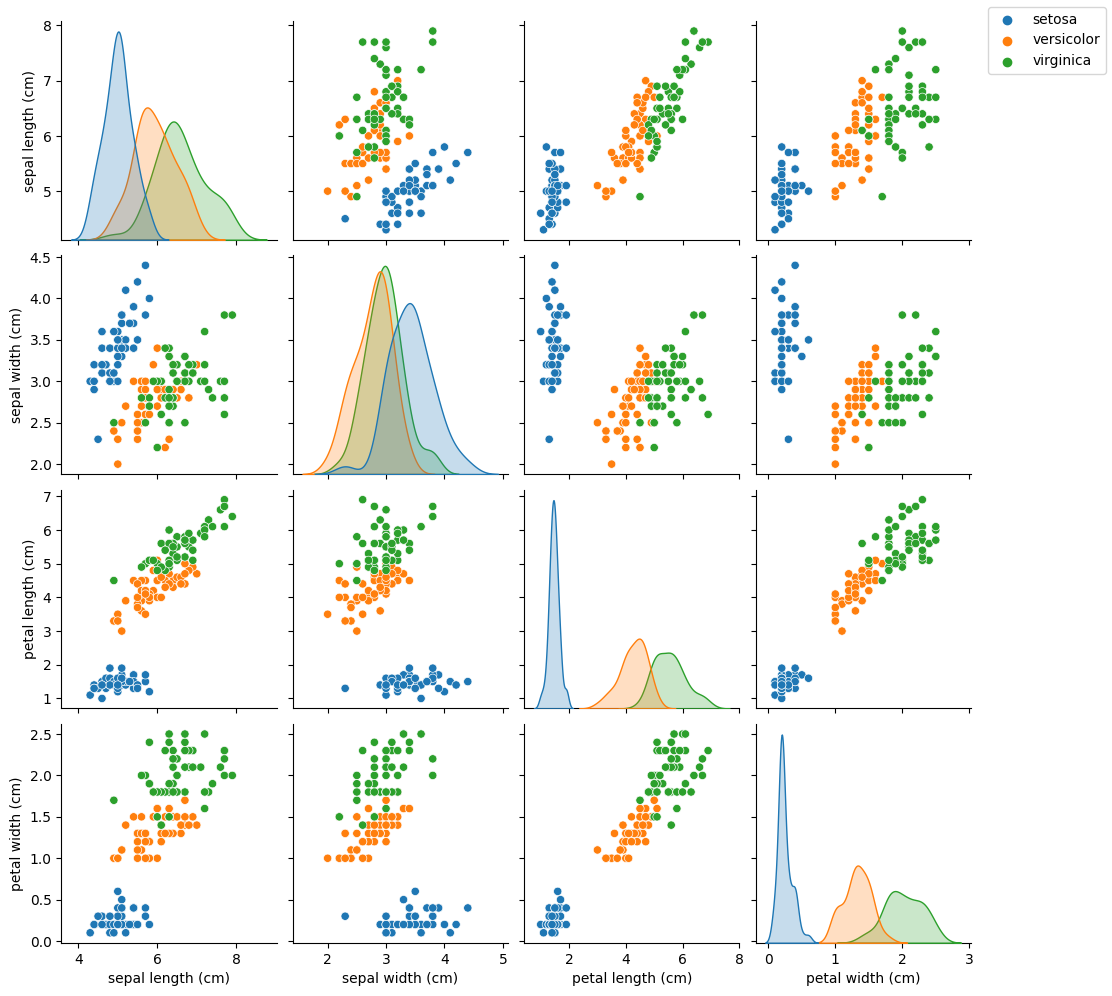

In [4]:
# Plot the pairwise relationships in the dataset
sns_plot = sns.pairplot(iris_df, vars=iris['feature_names'], hue="species")

# Move the legend on top of the plot
handles = sns_plot._legend_data.values()
labels = sns_plot._legend_data.keys()
sns_plot._legend.remove()
sns_plot.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=1)
sns_plot._legend.set_bbox_to_anchor((0.9, 0.6))  # adjust the values as needed

plt.show()

## Data on which Autoencoder was trained

In [5]:
normal_train_df.head()  # Versicolor - augmented samples
uniform_df_3.head()  # uniform noise - used in training

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.750871,5.324236,4.576230,4.716712
1,2.242967,3.805528,7.636482,5.876137
2,1.857232,4.824651,3.688483,6.653862
3,3.065652,4.277021,5.035100,9.585939
4,6.767247,8.126428,2.194396,3.399081


In [ ]:
scaler  # scaler was fitted on normal_train_df

StandardScaler()

In [ ]:
_feature_columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

X_normal_train_scaled = scaler.transform(normal_train_df[_feature_columns].to_numpy())  # Use scaler
X_normal_train_scaled_pt = torch.tensor(X_normal_train_scaled, dtype=torch.float32)

# Test set

In [ ]:
X_normal_test_df  # Normal class (Versicolor)

array([[5.12019493, 2.78051352, 4.01299406, 1.57449291],
       [6.66994422, 3.07516011, 4.94554232, 1.65014742],
       [5.69054416, 3.01191324, 4.33908679, 1.26613296],
       ...,
       [5.32797816, 2.44800193, 2.94453649, 1.16693306],
       [5.63660225, 2.74527766, 4.32337351, 1.28500329],
       [6.12419706, 2.87832257, 3.98071715, 1.27342508]])

In [ ]:
X_normal_scaled = scaler.transform(X_normal_test_df)  # Use scaler
X_normal_scaled_pt = torch.FloatTensor(X_normal_scaled)

In [ ]:
# Anonaly classes
X_anomaly_1_scaled = scaler.transform(X_anomaly_1_test_df)  # Setosa
X_anomaly_2_scaled = scaler.transform(X_anomaly_2_test_df)  # Virginica
X_anomaly_1_scaled_pt = torch.FloatTensor(X_anomaly_1_scaled)
X_anomaly_2_scaled_pt = torch.FloatTensor(X_anomaly_2_scaled)

# Load Autoencoder model

In [ ]:
# We skip training and load the model
model_iris = IrisAutoencoder3()
# If file cannot be loaded, it means it is corrupred an need to be downloaded once agian - see beginning of the notebook
model_iris.load_state_dict(torch.load('serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht'))

model_iris.eval()

IrisAutoencoder3(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=4, out_features=2, bias=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): ReLU(inplace=True)
  )
)

In [ ]:
### 3. Test autoencoder, visualise losses
print_loss(X_normal_scaled_pt, model_iris, f"Norm= {NORMAL_CLASS}")
print_loss(X_anomaly_1_scaled_pt, model_iris, f"Anomal1= {ANOMALY_CLASS_1}")
print_loss(X_anomaly_2_scaled_pt, model_iris, f"Anomal2= {ANOMALY_CLASS_2}")

[Norm= versicolor] test Loss= 0.9809625148773193
[Anomal1= setosa] test Loss= 17.665502548217773
[Anomal2= virginica] test Loss= 6.191577434539795


[ Norm= versicolor ] Cutoff Loss: 0.980962504453957
[ Anomal1= setosa ] Cutoff Loss: 17.665501726150513
[ Anomal2= virginica ] Cutoff Loss: 6.191577782154083


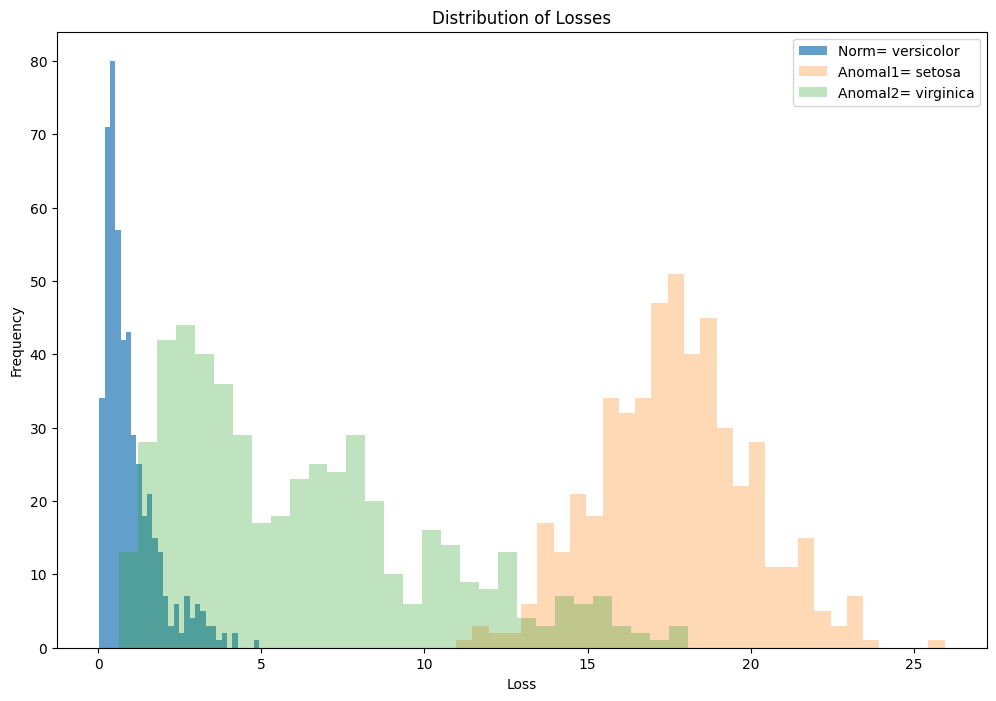

In [ ]:
# Visualise losses from Autoencoder
losses_normal_test, _ = get_losses_impl(X_normal_scaled_pt, model_iris, f"Norm= {NORMAL_CLASS}")
losses_anomaly_1_test, _ = get_losses_impl(X_anomaly_1_scaled_pt, model_iris, f"Anomal1= {ANOMALY_CLASS_1}")
losses_anomaly_2_test, _ = get_losses_impl(X_anomaly_2_scaled_pt, model_iris, f"Anomal2= {ANOMALY_CLASS_2}")

plt.figure(figsize=(12, 8))

plt.hist(losses_normal_test, bins=30, label=f"Norm= {NORMAL_CLASS}", alpha=0.7)
plt.hist(losses_anomaly_1_test, bins=30, label=f"Anomal1= {ANOMALY_CLASS_1}", alpha=0.3)
plt.hist(losses_anomaly_2_test, bins=30, label=f"Anomal2= {ANOMALY_CLASS_2}", alpha=0.3)

plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Fit AnomalyClassifier - it is wrapper fo Autoencoder

[ Norm= versicolor ] Cutoff Loss: 1.0361863668914884
Value at 90th percentile: 2.27
Data does not look Gaussian (reject H0).
Cutoff Loss: 1.0361863668914884
losses min= 0.01170929055660963, max= 4.399313926696777, threshold= 2.265178751945496
KS Test Result: Statistic = 0.10281468953410455, P-Value = 4.6936419702150854e-05
Data does NOT seem to fit a skew-normal distribution (KS Test P-value = 0.00005).


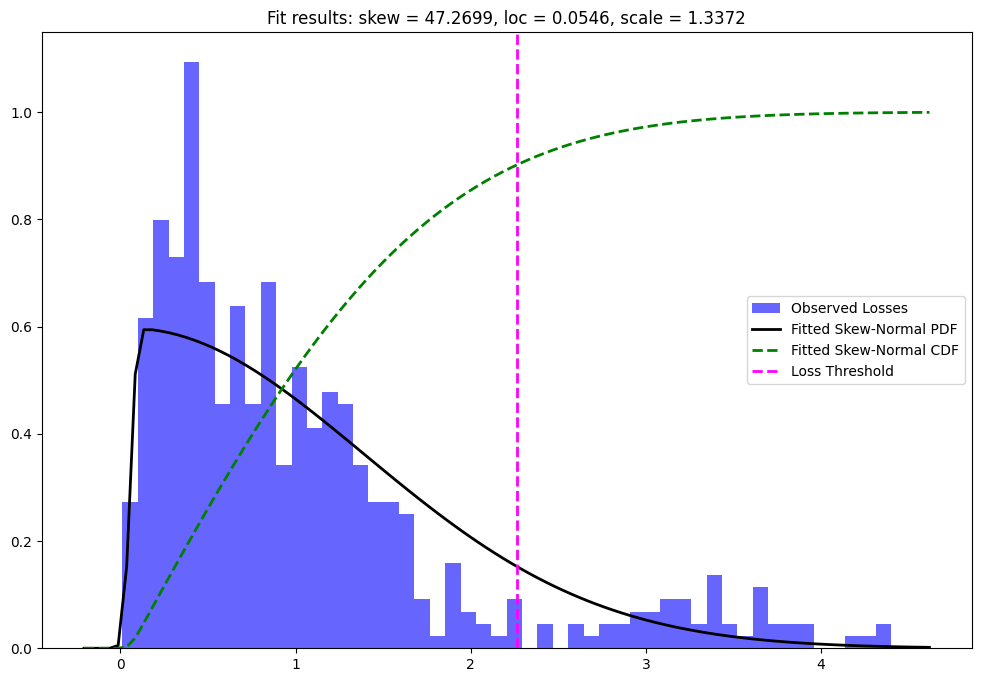

AnomalyClassifier(autoencoder_model=IrisAutoencoder3(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=4, out_features=2, bias=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Li...in_features=2, out_features=4, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): ReLU(inplace=True)
  )
),
                  get_losses=<function get_losses_impl at 0x7fb4ccd4e290>,
                  loss_threshold=2.265178751945496, scaler=StandardScaler())

In [ ]:
# Classifier is initialised soley on train - Normal class (Versicolor)
losses_normal_train, _ = get_losses_impl(X_normal_train_scaled_pt, model_iris, f"Norm= {NORMAL_CLASS}")

treshold_90, assessment = assess_gaussianity_and_percentile(losses_normal_train, 0.90)
print(f"Value at 90th percentile: {treshold_90:.2f}")
print(assessment)


model_classifier = AnomalyClassifier(autoencoder_model=model_iris,
                                     get_losses=get_losses_impl,
                                     loss_threshold=treshold_90,
                                     scaler=scaler)

# Predict proba is based on probability of loss being draw from distribution for train (Normal class - Versivolor)
model_classifier.initialise_predict_proba(X_normal_train_scaled_pt)

# How to get predictions from AnomalyClassifier on original data

In [ ]:
# Prepare data from iris_df
_feature_names = [n.replace(' ', '_').replace('(', '').replace(')', '') for n in iris_df.columns]
print("Features names:", ", ".join(_feature_names))
iris_df_cp = iris_df.copy()
iris_df_cp.columns = _feature_names
iris_df_cp.tail()

Features names: sepal_length_cm, sepal_width_cm, petal_length_cm, petal_width_cm, target, species


,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,target,species
145,6.7,3.0,5.2,2.3,2.0,virginica
146,6.3,2.5,5.0,1.9,2.0,virginica
147,6.5,3.0,5.2,2.0,2.0,virginica
148,6.2,3.4,5.4,2.3,2.0,virginica
149,5.9,3.0,5.1,1.8,2.0,virginica


In [ ]:
# # !!! Model predicts only 0 - normal and 1 - anomaly
predictions = model_classifier.predict(iris_df_cp[_feature_names[:-2]])

# Predict proba
probas = model_classifier.predict_proba(iris_df_cp[_feature_names[:-2]])

Cutoff Loss: 8.184709887057544
Cutoff Loss: 8.184709887057544


In [ ]:
predictions[-15:]

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [ ]:
probas[-15:]

array([[0.00000000e+00, 1.00000000e+00],
       [1.07229781e-11, 1.00000000e+00],
       [7.70495094e-02, 9.22950491e-01],
       [5.55594447e-01, 4.44405553e-01],
       [1.90111538e-04, 9.99809888e-01],
       [1.46890833e-10, 1.00000000e+00],
       [1.77803861e-06, 9.99998222e-01],
       [2.22466538e-01, 7.77533462e-01],
       [7.54226681e-11, 1.00000000e+00],
       [2.22044605e-15, 1.00000000e+00],
       [3.62143081e-06, 9.99996379e-01],
       [2.65920661e-01, 7.34079339e-01],
       [2.69743727e-02, 9.73025627e-01],
       [4.12659420e-08, 9.99999959e-01],
       [5.00733920e-01, 4.99266080e-01]])

# Your task starts here



# Explainable AI Assignment: Anomaly Detection with SHAP/LIME and LUX

## Overview
In this assignment, you will use the AnomalyClassifier, which predicts two classes: 0 (normal) and 1 (anomaly). Your task is to explain the predictions of this classifier using either SHAP, LIME, or LUX explainer. You will then evaluate the explanations based on three key metrics: Stability, Fidelity, and Consistency.

## Objectives
1. Apply a) SHAP or LIME and b) LUX to provide explanations for the AnomalyClassifier.
2. Calculate and analyze the following metrics for the chosen explainer:
   - Stability of Explanations
   - Fidelity of Explanations
   - Consistency

## Metrics Formulas
Here are the formulas for the metrics you need to compute:

### **1. Stability of Explanations**
Stability measures how minor changes in the instances being explained affect changes in the explanations. A stable explainer will show minimal differences in explanations for instances with small differences, especially if the model's prediction for these instances remains the same. Lower variance in explanations across different runs indicates higher stability.

Stability in this context is measured using local Lipschitz continuity in a fixed neighborhood of any datapoint. This approach evaluates how similar the explanations are for similar inputs. A lower value indicates higher stability, implying that small changes in input do not significantly alter the explanation.

$$
\text{Stability}_{\text{Lipschitz}} = \max_{i \neq j} \frac{\| \text{explanation}(x_i) - \text{explanation}(x_j) \|}{\| x_i - x_j \|}
$$

where \(||...||) denotes a norm (e.g., Euclidean), \( xi \) and \( xj \) are datapoints within the fixed neighborhood, and \(explanation(x)) is the explainer's output for datapoint \( x \).


### **2. Fidelity of Explanations**
Fidelity evaluates how closely the explainer's predictions align with the actual model predictions. It's calculated for 'n' instances.

The formula for Fidelity is as follows:

$$
\text{Fidelity} = \frac{1}{n} \sum_{i=1}^{n} \left(1 - |\text{prediction}_{i} - \text{explanation_prediction}_{i}|\right)
$$

  - `prediction_i`: Represents the actual prediction made by the model for the i-th instance.
  - `explanation_prediction_i`: Is the prediction given by the explainer for the same i-th instance.
  - `|prediction_i - explanation_prediction_i|`: The absolute difference between the model's prediction and the explainer's prediction measures the level of disagreement. Smaller differences indicate higher fidelity.
  - `1 - |prediction_i - explanation_prediction_i|`: This expression gives us a measure of agreement. A fidelity score close to 1 indicates a high level of agreement, suggesting that the explainer's predictions closely match those of the model.

  #### Applicability of the Method:

  This method of calculating fidelity is generally applicable to a range of explainers. However, it is important to note that the effectiveness of this metric can vary depending on the nature of the explainer and the model. With SHAP, which provides feature importance as explanations rather than direct predictions, the calculation of fidelity need to be adapted.
  ##### **Fidelity Calculation for SHAP Explainers**

    Fidelity in the context of SHAP explainers is calculated differently due to SHAP providing feature importances rather than direct predictions. The following method can be used to adapt fidelity calculation for SHAP:

    1. **Model Predictions:** Use your model to generate predictions for a dataset.

    2. **SHAP Explanations:** Generate SHAP feature importance explanations for the same instances.

    3. **Modify Input Data:** For each instance, modify the input data by altering the most important features according to SHAP (e.g., setting them to zero or replacing them with their mean value).

    4. **Re-Predict and Compare:** Use the model to predict again for these modified instances and compare these predictions with the original ones.

    5. **Calculate Fidelity:** Fidelity is calculated as a measure of how much predictions change after modifying the most important features identified by SHAP.

    Example Formula:

  $$
  \text{Fidelity}_{\text{SHAP}} = \frac{1}{n} \sum_{i=1}^{n} \left(1 - \text{change_in_prediction}(x_i, x'_i)\right)
  $$

    Where `xi` is the original instance, and `x'i` is the modified instance with changes based on SHAP feature importances. The function `change_in_prediction` measures the extent of change in the prediction between these two instances.

    This method of calculating fidelity for SHAP takes into account the impact of the most important features on the model's predictions, assessing how faithfully these importances reflect the model's behavior.


### **3. Consistency**
Consistency assesses the variance in explanations for the same instance across multiple runs. Lower variance signifies higher consistency.

The formula for Consistency is as follows:

$$
\text{Consistency} = 1 - \frac{\sum_{i=1}^{n} \text{variance}(\text{explanations}_{i})}{n}
$$

  - `variance(explanations_i)`: This represents the variance in the explanations generated for the i-th instance across different runs. A high variance indicates that the explainer's output varies significantly for the same instance, suggesting lower consistency.
  - The average of these variances over 'n' instances gives an overall measure of the explainer's consistency.
  - A higher consistency score (closer to 1) means that the explainer provides stable and reliable explanations across multiple evaluations.

## Instructions
1. Choose either SHAP or LIME and LUX as your explainer tool.
2. Apply the chosen explainer to the AnomalyClassifier to generate explanations for a set of instances.
3. Compute the Stability, Fidelity, and Consistency of the explanations using the above formulas.
4. Analyze the results to understand the effectiveness of your chosen explainer in making the AnomalyClassifier's decisions interpretable.

### General Note on Metric Convergence

For each of the metrics - Stability, Fidelity, and Consistency - it's crucial to aim for convergence over successive iterations. This means that with each iteration, the change in the metric's value should become progressively smaller. Achieving convergence indicates that the explainer's performance is consistent and reliable. If the metrics do not converge, it may suggest that the explainer's output is highly sensitive to small changes in the data or the modeling process, which can be a concern for the robustness of the explainer.

Remember, the goal of this assignment is to explore how explainable AI tools can help in understanding and interpreting machine learning models, particularly in anomaly detection scenarios.


In [ ]:
iris_df_cp["species"].value_counts()

In [ ]:
X_train_lux = iris_df_cp[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']].copy()
y_train_lux = iris_df_cp[['species']].copy()

# y_train_lux jest serią pandas
y_train_lux_encoded = y_train_lux.replace({'versicolor': 0.0, 'setosa': 1.0, 'virginica': 1.0})
y_train_lux_encoded.value_counts()

In [ ]:
model_classifier.predict_proba(X_train_lux[40:60])

In [ ]:
idx = 0
i2e = X_train_lux.iloc[idx].values.reshape(1, -1)
lux_obj = LUX(
          predict_proba=model_classifier.predict_proba,
          #classifier=model_classifier, #Uncomment to use SHAP=based sampling. This will take long time as the SHAP values will have to be recalculated for every split
          neighborhood_size=0.1, max_depth=3, node_size_limit=4, grow_confidence_threshold=0, min_samples=50)

In [ ]:
lux_obj.fit(X_train_lux, y_train_lux_encoded, instance_to_explain=i2e, inverse_sampling=True,
        oversampling=False,
        #Change to True i f you want to generate samples (note -- in current version is will take very long time to compute)
        prune=True, oblique=False)
lux_obj

In [ ]:
lux_obj.justify(i2e)

In [ ]:
lux_cf = lux_obj.counterfactual(i2e, background=X_train_lux, counterfactual_representative='nearest', topn=1)[0]
lux_cf['rule']

In [ ]:
i2edf = pd.DataFrame(i2e, columns=X_train_lux.columns)
lux_cf_nearest = lux_cf['counterfactual'].to_frame().T
lux_cf_nearest['class'] = model_classifier.predict(lux_cf_nearest)
i2edf['class'] = model_classifier.predict(i2edf)

lux_obj.uid3.tree.save_dot('tree-pure.dot', fmt='.2f')
graphviz.Source.from_file('tree-pure.dot')

In [ ]:
X_train_lux_bg = X_train_lux.copy()
X_train_lux_bg['class'] = y_train_lux_encoded
lux_obj.uid3.tree.save_dot('tree-cf-visual.dot', fmt='.2f', visual=True, background_data=X_train_lux_bg, instance2explain=i2edf,
                       counterfactual=lux_cf_nearest)
gvz = graphviz.Source.from_file('tree-cf-visual.dot')
!dot -Tpng./tree-cf-visual.dot > tree.png
Image('tree.png')